### About

This iPython notebook details the derivation of a 3- and 4-parameter likelihood functions. 

In brief, we wish to model the distribution of $\alpha$ or $\beta$ TCR chains observed per droplet during an emulsion-barcoding single-cell sequencing run. As we will see, a 3-parameter model fails to capture the long-tail of the experimental distribution. Consequently, a 4-parameter model, which incorporates an error in loading of cells into droplets, is necessary to accurately capture the expermeintal data. 

We first consider a minimal 3 parameter model: (1) a Poisson loading process with Poisson paramter $\lambda$, (2) an allelic inclusion rate with Binomial parameter $f$, and (3) experimental loss of an expressed TCR chain with Binomial paramter $s$. 

While we ultimately wish to capture experimental distributions, we begin first with a simulated dataset (for which each parameter is known *a priori*):


### Simulating the emulsion droplet dataset
Let's simulate some data $\{ x_1, x_2, ... , x_N \}$ where $x_i$ is the number of observed TCR chains in droplet $i$. For our simulation we will carry out the following stochastic procedure for each droplet:
- Step 1. Pick a random number of cells to be inserted into droplet $i$ with Poisson parameter $\lambda$.
- Step 2. Randomly assign some of the cells to exhibit allelic inclusion with probability $f$.
- Step 3. Randomly lose some of the TCR chains across the cells with probability $s$.
- Step 4. Make $x_i$ equal to the number of remaining (*i.e.* experimentally observed) chains.

In [1]:
from math import factorial as fac
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats, optimize
from scipy.stats import rv_discrete
import pandas as pd
import warnings
from numba import jit
%matplotlib inline

In [2]:
#Simulation code
def counts_from_x(x):
    """
    Utility function. 
    Input list of chains per droplet ({x_0...x_i})
    Output vector containing number of droplets containing i chains (V_i=droplets with i chains)
    """
    counts_max=int(np.max(x))       
    counts=np.array([np.sum(1*x==i) for i in range(counts_max+1)])
    return counts

@jit
def loop(N,total_cells,allelic,chains,f_real,s_real,x,counts,counts_m):
    """
    Runs simulation. Contains no Python statements to allow use of numba's @jit. 
    Iterate through N total droplets. For each droplet, consider:
    (1) Poisson loading
    (2) Binomial allelic inclusion
    (3) Binomial chain dropout
    Return total number of observed chains for each droplet
    """    
    for t in range(N): #iteratre through N droplets
        cells_per_drop=total_cells[t] #cells per droplet
        random_allelic=allelic[counts:counts+cells_per_drop] #Assign random number (between 0 and 1) to each droplet
        counts=counts+cells_per_drop
        m=np.sum(1*(random_allelic<f_real))   #Determine number of allelic inclusion cells in droplet
        random_chains=chains[counts_m:counts_m+m+cells_per_drop] #Assign random number to each chain in droplet
        counts_m=counts_m+m+cells_per_drop
        x[t]=int(np.sum(1*(random_chains>s_real))) #Determine number of observed chains per droplet
    return counts_from_x(x) #Return distribution of chains observed per droplet

def simulate(N,la,f,s):
    """
    Initiliaze and call simulation. Input:
    (1) number of chains to simulate (N)
    (2) Possion loading rate (la)
    (3) Allelic inclusion rate (f)
    (4) Chain dropout rate (s)
    """
    ztp_distribution=[(np.exp(-la)*la**x)/((1-np.exp(-la))*fac(x)) for x in range(1,50)] #zero-truncated poissson distribution
    lambdas=rv_discrete(values=(range(1,50),ztp_distribution)).rvs(size=int(N)) #Sample from ZTP
    total_cells=lambdas #Number of cells per droplet
    allelic=np.random.rand(np.sum(total_cells)) #Random number to determine whether a given cell is allelic inclusion cell
    chains=np.random.rand(int(2*np.sum(total_cells))) #Random number to determine whether a given chain is observed
    x=np.zeros(N) 
    counts=loop(N,total_cells,allelic,chains,f,s,x=np.zeros(N),counts=0,counts_m=0)
    return counts[:12]

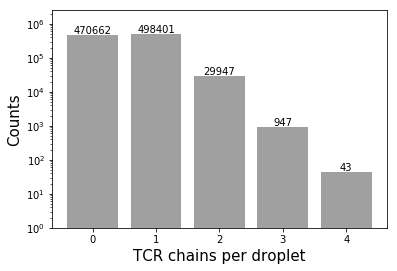

In [3]:
##Run Simulation

#Define simulation parameters
N=int(1e6) # number of droplets to simulate
la_real=0.08 #Poisson loading rate
f_real=0.08 #Allelic inclusion rate
s_real=0.5 #TCR chain droupout rate

counts=simulate(N,la_real,f_real,s_real) # runs simulation with defined parameters. 
                                           #counts=number of droplets with x_i TCR chains
#Visualize simulated distributions
def vis_sim_dist(counts):
    plt.bar(range(len(counts)),counts,color='Gray',alpha=0.75)
    plt.xlabel('TCR chains per droplet',fontsize=15)
    plt.ylabel('Counts',fontsize=15)
    plt.yscale('log')
    [plt.text(i,counts[i]*1.1,'%d' % counts[i],ha='center',color='k') for i in np.arange(len(counts))]
    plt.ylim([1,np.max(counts)*5])
    plt.show()
    plt.close()
vis_sim_dist(counts)

## Derivation of likelihood generating function

From this distribution of chains/droplet, we wish to infer the following parameters:
- $\lambda$: Poisson rate of cells per droplet
- $f$: allelic inclusion rate
- $s$: probability of not observing a chain 

### Modeling a single droplet
Here are some of the simpler droplet models that may occur in our experiment:

$$
\begin{array}
\
p_A&=e^{-\lambda}& \hspace{0.5in} \text{no cell} \\
p_B&=(1-f) e^{-\lambda} \lambda& \hspace{0.5in} \text{1 normal cell}\\
p_C&=f e^{-\lambda} \lambda& \hspace{0.5in} \text{1 inclusion cell} \\
p_D&=(1-f)^2 \displaystyle{\frac{e^{-\lambda} \lambda^2}{2}}& \hspace{0.5in} \text{2 normal cells} \\
p_E&=2f(1-f) \displaystyle{\frac{e^{-\lambda} \lambda^2}{2}}& \hspace{0.5in} \text{1 normal, 1 inclusion} \\
p_F&=f^2 \displaystyle{\frac{e^{-\lambda} \lambda^2}{2}}& \hspace{0.5in} \text{2 inclusion cells} \\
p_G&=(1-f)^3 \displaystyle{\frac{e^{-\lambda} \lambda^3}{6}}& \hspace{0.5in} \text{3 normal cells} \\
p_H&=3f(1-f)^2 \displaystyle{\frac{e^{-\lambda} \lambda^3}{6}}& \hspace{0.5in} \text{2 normal cells, 1 inclusion} \\
&...&
\end{array}
$$

We first model the probability of loading a given number of cells ($c$) into a single droplet droplet as a Poisson process:

$$
\begin{array}
\
p(c|\lambda)&=&\displaystyle \frac{e^{-\lambda} \lambda^{c}}{c!} \hspace{5mm} \text{for} \hspace{2mm} c=0,1,2,...
\end{array}
$$

Note, however, that this distribution includes droplets containing zero cells and thereby zero chains. Without any chains, nothing from these droplets will not be sequenced and consequently are experimentally unobservable. In order to account for this, we instead describe the loading process using a zero-truncated Poisson distrubtion:

$$
\begin{array}
\
p(c|\lambda)&=&\displaystyle \frac{e^{-\lambda} \lambda^{c}}{(1-e^{-\lambda}) c!} \hspace{5mm} \text{for} \hspace{2mm} c=1,2,...
\end{array}
$$

In general, a single droplet may have  $m$ inclusion cells and $n$ exclusion (normal) cells. Thus, each droplet has $c=m+n$ total cells, giving us:

$$
\begin{array}
\
p(n,m|\lambda)&=&\displaystyle \frac{e^{-\lambda} \lambda^{m+n}}{(1-e^{-\lambda})(m+n)!} \hspace{5mm} \text{for} \hspace{2mm} (m+n)\neq0
\end{array}
$$

We next model the number of $m$ inclusions cells with a Binomial distribution (probability $f$). Combining this with the Poisson loading process (allelic inclusion is independent of the loading process), we find that the probability of seeing $m$ and $n$ cells in a droplet is:

$$
\begin{array}
\
p(m,n|\lambda,f)&=&\displaystyle \overbrace{\frac{e^{-\lambda} \lambda^{m+n}}{(1-e^{-\lambda})(m+n)!}}^{\text{Poisson distribution}} \overbrace{\frac{(m+n)!}{m!n!} f^m (1-f)^n}^{\text{Binomial distribution}} \hspace{5mm}
\end{array}
$$

Simplyfying, we can write:

$$
\begin{array}
\
p(m,n|\lambda,f)&=& \displaystyle \frac{e^{-\lambda} \lambda^{m+n} f^m (1-f)^n}{(1-e^{-\lambda})m!n!} \hspace{5mm} \text{where} \hspace{2mm} (m+n)\geq1
\end{array}
$$

For a droplet loaded with $c$ cells, $n$ of which are normal (express 1 chain) and $m$ of which are allelic inclusion cells (express 2 chains), there are $n+2m$ chains. 

In practice, however, we will only observe some number $x$ of the $n+2m$ chains present in the droplet. While there are many potential steps at which a chain could potentially be lost (failure to amplify during PCR, failure to sequence above a cutoff depth, etc.), we will assume there is some single probability $s$ of not seeing a chain present the droplet.

Additionally, there becomes more than one way to observe $x$ chains per droplet once we allow for the experimental loss of some chains. For example, a droplet with 1 observed chain can be generated with $n$=1 and no dropout or $m$=1 with the loss of one chain. In order to determine the probability of observing $x$ chains in a droplet, we must sum over all the possible ways of generating $n+2m$ chains in a droplet. 

Thus, the probability of observing $x$ chains is given as:

$$
\begin{array}
\
p(x|\lambda,f,s)&=&\displaystyle \sum_{m,n} p(x|m,n,\lambda,f,s) p(m,n|\lambda,f) \\
&=&\displaystyle \sum_{m,n} p(x|m,n,s) p(m,n|\lambda,f) 
\end{array}
$$

Observing that $p(m,n|\lambda,f)$ is given above and modeling the dropout rate with a Binomial distribution with dropout probability $s$, we find that:

$$
\begin{array}
\
p(x|\lambda,f,s)&=&\displaystyle \sum_{m,n} \overbrace{\left( \frac{(2m+n)!}{(2m+n-x)!x!} s^{2m+n-x}(1-s)^{x} \right)}^{\text{Binomial distribution}} \left( \frac{e^{-\lambda} \lambda^{m+n} f^m (1-f)^n}{(1-e^{-\lambda})m!n!} \right)
\end{array}
$$

Rearranging and again noting that we don't experimentally observe droplets with no cells ($m+n>0$), we arrive at:

$$
\begin{array}
\
p(x|\lambda,f,s)&=&\displaystyle \frac{(1-s)^x e^{-\lambda}}{(1-e^{-\lambda})x!} \sum_{2m+n \geq x\geq1} \frac{(2m+n)!}{(2m+n-x)!m!n!} s^{2m+n-x} (1-f)^n f^m \lambda^{m+n}
\end{array}
$$





In [4]:
#Direct implementation of likelihood generating function
def px(x,la,f,s,m_max=4,n_max=5):
    """p(x|lambda,f,s)
        x = number of observed chains
        la,f,s= proposed values for loading, inclusion, and dropout rates
        m_max = max number of inclusion cells in droplet
        n_max = max number of normal cells in droplet
        """     
    prefactor=(((1-s)**x)*np.exp(-la))/(fac(x)*(1-np.exp(-la)))
    ans=0
    for m in range(m_max+1):
        for n in range(n_max+1):
            if ((2*m)+n)>=x and (m+n)!=0:
                ans+=(fac((2*m)+n)*(s**((2*m)+n-x))*((1-f)**n)*(f**m)*(la**(m+n)))/(fac((2*m)+n-x)*fac(m)*fac(n))
    return prefactor*ans

R²= 0.9999968630736131


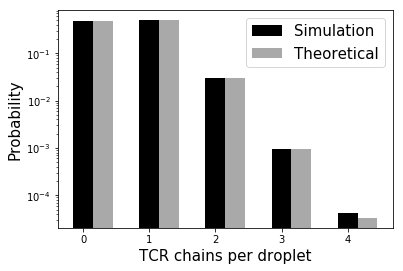

In [5]:
#Compare simulated vs. model (with real parameters) distributions
def sim_v_model(counts):
    plt.bar(range(len(counts)),counts/N,width=0.3,label='Simulation',color='k')
    plt.bar(np.arange(len(counts))+0.3,[px(i,la_real,f_real,s_real) for i in range(len(counts))],width=0.3,label='Theoretical',color='DarkGray')
    stat=stats.linregress(counts,[px(i,la_real,f_real,s_real) for i in range(len(counts))])
    print('R\u00b2=',stat[2]**2)
    plt.xlabel('TCR chains per droplet',fontsize=15)
    plt.ylabel('Probability',fontsize=15)
    plt.yscale('log')
    plt.legend(fontsize=15)
    plt.show()
    plt.close()
sim_v_model(counts)

### Infering parameters with maximum likelihood estimation

We want to use our likelihood generating function to estimate parameters given some experimental dataset.

#### Likelihood
$$
\begin{array}
\
L&=&p({\rm data }|\lambda,f,s) \\
&=&\displaystyle \prod_i^N p(x_i|\lambda,f,s) \\
&=&\displaystyle \prod_i^N \sum_{2m+n \geq x_i} \frac{(2m+n)!}{(2m+n-x_i)!x_i!m!n!} s^{2m+n-x_i} (1-s)^{x_i} (1-f)^n f^m \lambda^{m+n} e^{-\lambda}
\end{array}
$$
#### Log-likelihood
$$
\begin{array}
\
\mathcal{L}&=& \ln p({\rm data }|\lambda,f,s) \\
&=& \displaystyle \sum_i^N \ln p(x_i|\lambda,f,s) \\
&=& \displaystyle \sum_{t=0}^{\max(x)} c_t \ln p(x=t|\lambda,f,s)
\end{array}
$$
where $c_t$ is the number of droplets that contain $t$ chains.
#### Log-likelihood per datum
For large $N$ the log-likelihood of the entire dataset can be a large negative value. It can be convenient to consider the average log-likelihood 
$$
\begin{array}
\
\mathcal{l}&=& \displaystyle \frac{1}{N} \ln p({\rm data }|\lambda,f,s) \\
&=& \displaystyle \frac{1}{N} \sum_{t=0}^{\max(x)} c_t \ln p(x=t|\lambda,f,s)
\end{array}
$$

In [6]:
#Code for likelihood
def LL(theta):
    la,f,s=theta
    'Log-likelihood: log p(data|lambda,f,s)'
    LL=np.sum([counts[i]*np.log(px(i,la,f,s)) for i in range(0,len(counts))])/np.sum(counts)
    return -LL

In [7]:
#Optimize likelihood function using scipy.optimize.minimize
def optimization(counts,N_random_starts=50):
    warnings.simplefilter(action='ignore')
    method=['L-BFGS-B','Nelder-Mead']
    N_methods=len(method)
    for starting in range(N_random_starts):
        x0=[np.random.random(1),np.random.random(1),np.random.random(1)]
        data=np.empty((N_methods,5),dtype=object)
        for it,methods in enumerate(method):
            try:
                minimum=optimize.minimize(LL,x0,method=methods,bounds=((0,1),(0,1),(0,1)))
            except:
                minimum=optimize.minimize(LL,x0,method=methods)
            data[it]=np.hstack((minimum.x,minimum.fun,methods))

        if starting==0:
            df=data
        else:
            df=np.vstack((df,data))
    df=pd.DataFrame(df,columns=['la','f','s','energy','method'])
    df=df.sort_values(by=['energy'])
    df=df[df['energy'].astype(float)>0]
    df=df[df.la.astype(float)>0.001]
    return df
df=optimization(counts,N_random_starts=50)

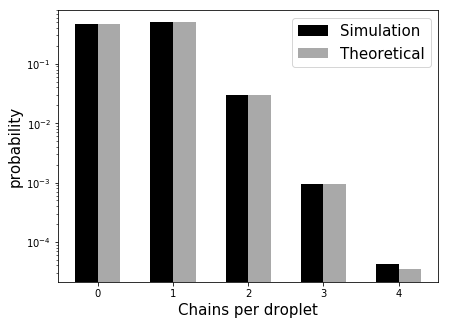

Real vs. maximum likelihood estimates
Allelic inclusion: Real- 0.080 vs. Estimated- 0.079 (1.4% difference)
Lambda: Real- 0.080 vs. Estimated- 0.083 (3.7% difference)
Dropout: Real- 0.500 vs. Estimated- 0.501 (0.1% difference)
R²= 0.9999999992930861


In [8]:
def accuracy(counts,df,la_real=None,f_real=None,s_real=None):
    N=np.sum(counts)
    stat=stats.linregress(counts,[px(i,float(df.iloc[0]['la']),float(df.iloc[0]['f']),float(df.iloc[0]['s'])) for i in range(len(counts))])
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.bar(range(len(counts)),counts/N,width=0.3,label='Simulation',color='Black')
    plt.bar(np.arange(len(counts))+0.3,[px(i,float(df.iloc[0]['la']),float(df.iloc[0]['f']),float(df.iloc[0]['s'])) for i in range(len(counts))],width=0.3,label='Theoretical',color='DarkGray')
    plt.xticks(np.arange(len(counts))+0.15,np.arange(len(counts)))
    plt.xlabel('Chains per droplet',fontsize=15)
    plt.ylabel('probability',fontsize=15)
    plt.yscale('log')
    plt.legend(fontsize=15)
    plt.show()
    plt.close()
    try:
        print('Real vs. maximum likelihood estimates')
        print('Allelic inclusion: Real- {:.3f} vs. Estimated- {:.3f} ({:.1f}% difference)'.format(f_real,float(df.iloc[0]['f']),np.absolute((f_real-float(df.iloc[0]['f']))/f_real)*100))
        print('Lambda: Real- {:.3f} vs. Estimated- {:.3f} ({:.1f}% difference)'.format(la_real,float(df.iloc[0]['la']),np.absolute((la_real-float(df.iloc[0]['la']))/la_real)*100))
        print('Dropout: Real- {:.3f} vs. Estimated- {:.3f} ({:.1f}% difference)'.format(s_real,float(df.iloc[0]['s']),np.absolute((s_real-float(df.iloc[0]['s']))/s_real)*100))
        print('R\u00b2=',stat[2]**2)
    except:
        print('Real vs. maximum likelihood estimates')
        print('Allelic inclusion: Estimated- {:.3f}'.format(float(df.iloc[0]['f'])))
        print('Lambda: Estimated- {:.3f}'.format(float(df.iloc[0]['la'])))
        print('Dropout: Estimated- {:.3f}'.format(float(df.iloc[0]['s'])))
        print('R\u00b2=',stat[2]**2)

accuracy(counts,df,la_real,f_real,s_real)

## Fitting alpha and beta distributions together

Ideally, it would be possible to fit the joint distribution of alpha and beta chains (*i.e.* model the frequency of droplets containing $x_\alpha$ TCR$\alpha$ and $x_\beta$ TCR$\beta$ chains). That is, while we are currently solving the following single-chain inference problem:

$$
\begin{array}
\
L&=&p({\rm data }|\lambda,f,s) 
\end{array}
$$

where data is either the experimental $\alpha$ **or** $\beta$ TCR chain distributions. Ideally, we would solve:

$$
\begin{array}
\
L&=&p({\rm data_\alpha, data_\beta }|\lambda,f_\alpha,f_\beta,s_\alpha,s_\beta) 
\end{array}
$$

We here note that while the allelic inclusion rate $f$ and dropout rate $s$ may vary between chain types, the loading rate of cells remains constant for each chain type. While it is highly unlikely that the capture $\alpha$ and $\beta$ chains are truly independent, we nevertheless make the simplyfing assumption of conditional independence. Thus, 

$$
\begin{array}
\
L&=&p({\rm data_\alpha, data_\beta }|\lambda,f_\alpha,f_\beta,s_\alpha,s_\beta)
L &\approx& p({\rm data_\alpha }|\lambda,f_\alpha,s_\alpha) \cdot p({\rm data_\beta}|\lambda,f_\beta,s_\beta)
\end{array}
$$

And the log likelihood becomes:

$$
\begin{array}
\
\mathcal{L}&=& \displaystyle\sum_{t=0}^{\max(x)}  \left(c_{t,\alpha} \ln p(x_\alpha=t|\lambda,f_\alpha,s_\alpha) + c_{t,\beta} \ln  p(x_\beta=t|\lambda,f_\beta,s_\beta)\right)
\end{array}
$$


Let's simulate new alpha and beta distributions with same loading parameter:

In [9]:
#Simulate alpha and beta distributions with same loading parameter
counts_alpha=counts
f_real_a=f_real
s_real_a=s_real

N_b=int(6e5) # number of droplets to simulate
la_real=0.08 #Poisson loading rate
f_real_b=0.04 #Allelic inclusion rate
s_real_b=0.35 #TCR chain droupout rate
counts_beta=simulate(N_b,la_real,f_real_b,s_real_b)

In [10]:
#Paired likelihood function
def LL_opt_paired(params):
    la,f_a,s_a,f_b,s_b=params
    'Log-likelihood: log p(data|lambda,f,s)'
    LLa=np.sum([counts_alpha[i]*np.log(px(i,la,f_a,s_a)) for i in range(0,len(counts_alpha))])/np.sum(counts_alpha)
    LLb=np.sum([counts_beta[i]*np.log(px(i,la,f_b,s_b)) for i in range(0,len(counts_beta))])/np.sum(counts_beta)
    return (-LLa)+(-LLb)

In [11]:
#Redefine optimization function for alpha/beta distributions with same lambda
def optimization_paired(counts_alpha,counts_beta,N_random_starts=50):
    warnings.simplefilter(action='ignore')
    method=['TNC','SLSQP','L-BFGS-B','Nelder-Mead']
    N_methods=len(method)
    for starting in range(N_random_starts):
        data=np.empty((N_methods,7),dtype=object)
        for it,methods in enumerate(method):
            x0=[np.random.random(1),np.random.random(1),np.random.random(1),np.random.random(1),np.random.random(1)]
            try:
                minimum=optimize.minimize(LL_opt_paired,x0,method=methods,bounds=((0,1),(0,1),(0,1)))
            except:
                minimum=optimize.minimize(LL_opt_paired,x0,method=methods)
            data[it]=np.hstack((minimum.x,minimum.fun,methods))
        if starting==0:
            df=data
        else:
            df=np.vstack((df,data))
    df=pd.DataFrame(df,columns=['la','f_a','s_a','f_b','s_b','energy','method'])
    df=df.sort_values(by=['energy'])
    df=df[df['energy'].astype(float)>0]
    df=df[df.la.astype(float)>0.001]
    return df

In [12]:
df=optimization_paired(counts_alpha,counts_beta,N_random_starts=50)

In [13]:
def accuracy_paired(counts_alpha,counts_beta,df,simulate=1):
    names=['Alpha','Beta']
    rowname_f=['f_a','f_b']
    rowname_s=['s_a','s_b']
    if simulate==1:
        s_real=[s_real_a,s_real_b]
        f_real=[f_real_a,f_real_b]
    plt.figure(figsize=(15,5))
    for j,counts in enumerate([counts_alpha,counts_beta]):
        N=np.sum(counts)
        stat=stats.linregress(counts,[px(i,float(df.iloc[0]['la']),float(df.iloc[0][rowname_f[j]]),float(df.iloc[0][rowname_s[j]])) for i in range(len(counts))])
        plt.subplot(1,2,j+1)
        plt.bar(range(len(counts)),counts/N,width=0.3,label='Simulation',color='Black')
        plt.bar(np.arange(len(counts))+0.3,[px(i,float(df.iloc[0]['la']),float(df.iloc[0][rowname_f[j]]),float(df.iloc[0][rowname_s[j]])) for i in range(len(counts))],width=0.3,label='Theoretical',color='DarkGray')
        plt.xticks(np.arange(len(counts))+0.15,np.arange(len(counts)))
        plt.xlabel(f'{names[j]} chains per droplet',fontsize=15)
        plt.ylabel('probability',fontsize=15)
        plt.yscale('log')
        plt.legend(fontsize=15)
        
        print(f'{names[j]} Real vs. Maximum likelihood estimates')
        
        if simulate==1:
            try:
                print('Allelic inclusion: Real- {:.3f} vs. Estimated- {:.3f} ({:.1f}% difference)'.format(f_real[j],float(df.iloc[0][rowname_f[j]]),np.absolute((f_real[j]-float(df.iloc[0][rowname_f[j]]))/f_real[j])*100))
                print('Lambda: Real- {:.3f} vs. Estimated- {:.3f} ({:.1f}% difference)'.format(la_real,float(df.iloc[0]['la']),np.absolute((la_real-float(df.iloc[0]['la']))/la_real)*100))
                print('Dropout: Real- {:.3f} vs. Estimated- {:.3f} ({:.1f}% difference)'.format(s_real[j],float(df.iloc[0][rowname_s[j]]),np.absolute((s_real[j]-float(df.iloc[0][rowname_s[j]]))/s_real[j])*100))
                print('R\u00b2=',stat[2]**2)
            except: 
                print('Allelic inclusion: Estimated- {:.3f}'.format(float(df.iloc[0][rowname_f[j]])))
                print('Lambda: Estimated- {:.3f}'.format(float(df.iloc[0]['la'])))
                print('Dropout: Estimated- {:.3f}'.format(float(df.iloc[0][rowname_s[j]])))
                print('R\u00b2=',stat[2]**2)
        else:
            print('Allelic inclusion: Estimated- {:.3f}'.format(float(df.iloc[0][rowname_f[j]])))
            print('Lambda: Estimated- {:.3f}'.format(float(df.iloc[0]['la'])))
            print('Dropout: Estimated- {:.3f}'.format(float(df.iloc[0][rowname_s[j]])))
            print('R\u00b2=',stat[2]**2)
        print('\n')
    plt.show()
    plt.close()

Alpha Real vs. Maximum likelihood estimates
Allelic inclusion: Real- 0.080 vs. Estimated- 0.081 (1.3% difference)
Lambda: Real- 0.080 vs. Estimated- 0.079 (1.3% difference)
Dropout: Real- 0.500 vs. Estimated- 0.501 (0.2% difference)
R²= 0.9999999894297049


Beta Real vs. Maximum likelihood estimates
Allelic inclusion: Real- 0.040 vs. Estimated- 0.041 (3.4% difference)
Lambda: Real- 0.080 vs. Estimated- 0.079 (1.3% difference)
Dropout: Real- 0.350 vs. Estimated- 0.349 (0.2% difference)
R²= 0.9999999824557638




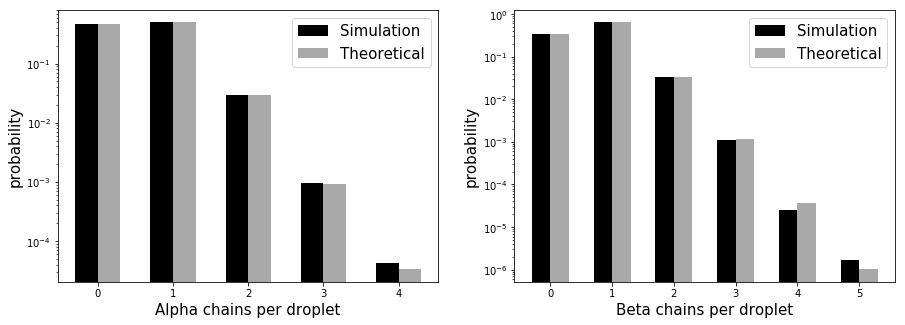

In [14]:
accuracy_paired(counts_alpha,counts_beta,df)

## Experimental distributions

Clearly, our likelihood model does not capture the long-tail of our experimental distributions.

In [15]:
counts_alpha=np.array([818819, 795095, 73104, 7880, 1560, 558, 212, 131, 67, 46, 24, 12, 16, 11, 3, 3, 1, 1, 3, 1, 1, 2])
counts_beta=np.array([602628, 989821, 90413, 10733, 2261, 762, 376, 224, 116, 75, 54, 25, 14, 18, 10, 4, 5, 1, 1, 5, 2, 1, 1])

counts_alpha=counts_alpha[:12]
counts_beta=counts_beta[:12]

Alpha Real vs. Maximum likelihood estimates
Allelic inclusion: Estimated- 0.093
Lambda: Estimated- 0.271
Dropout: Estimated- 0.539
R²= 0.9998858497533996


Beta Real vs. Maximum likelihood estimates
Allelic inclusion: Estimated- 0.050
Lambda: Estimated- 0.271
Dropout: Estimated- 0.399
R²= 0.9996331911454932




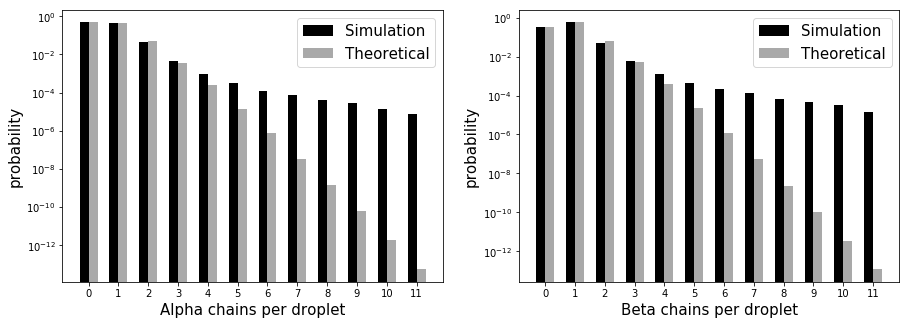

In [16]:
#Same lambda
df=optimization_paired(counts_alpha,counts_beta,N_random_starts=50)
accuracy_paired(counts_alpha,counts_beta,df,simulate=0)

## Addressing the long-tail of the experimental distributions


Clearly, our current maximum-likelihood estimation method fails to capture the distribution's long tail ($\geq\sim$4 chains per droplet). Biologically, the number of (either $\alpha$ or $\beta$) chains per cell is capped at 2 alleles, and consequently all droplets with more than 2 chains come from experimental errors ($\textit{e.g.}$ multiple cells per droplet, degeneracy in droplet barcodes, $\textit{etc.}$). 

Recall that under our current model, we model the loading ($L$) of cells in droplets as a single Poisson process (experimentally measure to have a mean of $\sim$0.2 cells per droplet). As droplets without cells are unobserved, we augmented this as a zero-truncated Poisson, such that the loading of normal ($n$) and allelic inclusion ($m$) cells is given as:

$$
\begin{array}
\
p_{L}(n,m|\lambda)&=&\displaystyle \frac{e^{-\lambda} \lambda^{m+n}}{(1-e^{-\lambda})(m+n)!} \hspace{5mm} \text{for} \hspace{2mm} (m+n)\neq0
\end{array}
$$

In order to account for the long tail seen in the experimental distributions, we add an additional loading term which follows a power-law distribution. Specifically, we model the experimental error ($E$) of adding additinal cells to each droplet. We empirically model this error loading term with the PDF:

$$
\begin{array}
\
p_E(n,m|\gamma)&=&\displaystyle \frac{(m+n)^{-\gamma}}{\zeta(\gamma,(m+n)_{min})} &=&\displaystyle \frac{(m+n)^{-\gamma}}{\sum\limits_{k=0}^{\infty}  (k+(m+n)_{min})^{-\gamma}} \hspace{5mm} \text{for} \hspace{2mm} (m+n)\geq1
\end{array}
$$

However, we expect that, in most cases, the error term is not present and thus does contribute to the number of cells per droplet ($\textit{i.e.}$ $m+n=0$ in most cases). We thus modify the power law distribution to begin at 0, such that: 

$$
\begin{array}
\
p_{E}(n,m|\gamma)&=&\displaystyle \frac{(m+n+1)^{-\gamma}}{\zeta(\gamma,1)} \hspace{5mm} \text{for} \hspace{2mm} (m+n)\geq0
\end{array}
$$

Observe that $p_{L}$ and $p_{E}$ are discrete distributions. We now wish to define some new discrete distribution ($p_{T}$), such that T=L+E. Recall that the convolution of two discrete distributions is given in the general form:

$$
\begin{array}
\
p_{T}(z)&=&\displaystyle \sum\limits_{k=-\infty}^{\infty} p_{L}(k)p_{E}(z-k)
\end{array}
$$

Given that $p_L$ is defined only for over the interval \[1,$\infty$\] and $p_E$ is defined only for over the interval \[0,$\infty$\], we find that:

$$
\begin{array}
\
p_{T}(z)&=&\displaystyle \sum\limits_{k=1}^{z} p_{L}(k)p_{C}(z-k) \hspace{5mm} \text{for} \hspace{2mm} z\geq1
\end{array}
$$

And for $m$ and $n$ cells:

$$
\begin{array}
\
p_{T}(n,m|\lambda,\gamma)&=&\displaystyle \sum\limits_{k=1}^{n+m} p_{L}(k)p_{C}(n+m+1-k)&=&\displaystyle \sum\limits_{k=1}^{n+m} \frac{e^{-\lambda} \lambda^{k}}{(1-e^{-\lambda})(k)!} \frac{(n+m+1-k)^{-\gamma}}{\zeta(\gamma,1)} \hspace{5mm} \text{for} \hspace{2mm} (n+m)\geq1
\end{array}
$$

Reducing:

$$
\begin{array}
\
p_{T}(n,m|\lambda,\gamma)&=&\displaystyle \sum\limits_{k=1}^{n+m} \frac{e^{-\lambda} \lambda^{k}(n+m+1-k)^{-\gamma}}{(1-e^{-\lambda})\zeta(\gamma,1)k!}\hspace{5mm} \text{for} \hspace{2mm} (n+m)\geq1
\end{array}
$$

Incorporating allelic inclusion ($f$) and dropout ($s$), the probability of observing $x$ chains in a given droplet is given as:

$$
\begin{array}
\
p(x|\lambda,\gamma,f,s)&=&\displaystyle \sum_{m,n}  \overbrace{\left(\sum\limits_{k=1}^{n+m} \frac{e^{-\lambda} \lambda^{k}(n+m+1-k)^{-\gamma}}{(1-e^{-\lambda})\zeta(\gamma,1)k!}\right)}^{\text{Cell Loading}} \overbrace{\left(\frac{(m+n)!}{m!n!} f^m (1-f)^n\right)}^{\text{Inclusion rate}} \overbrace{\left( \frac{(2m+n)!}{(2m+n-x)!x!} s^{2m+n-x}(1-s)^{x} \right)}^{\text{Binomial distribution}}
\end{array}
$$


Simplifying yields: 

$$
\begin{array}
\
p(x|\lambda,\gamma,f,s)&=&\displaystyle \frac{e^{-\lambda}(1-s)^x}{(1-e^{-\lambda})\zeta(\gamma,1)x!} \sum_{2m+n \geq x\geq1} \left(\sum\limits_{k=1}^{n+m} \frac{\lambda^{k}(n+m+1-k)^{-\gamma}}{k!}\right)\left(\frac{(m+n)!f^{m}(1-f)^{n}(2m+n)!s^{2m+n-x}}{(2m+n-x)!m!n!}\right)
\end{array}
$$

In [17]:
#4 parameter simulation
def simulate(N,la,ga,f,s):
    """
    Update simulate def from 3 parameter model.
    Now includes error loading term (ga)
    """
    ztp_distribution=[(np.exp(-la)*la**x)/((1-np.exp(-la))*fac(x)) for x in range(1,50)] #zero-truncated poissson (ZTP) distribution
    lambdas=rv_discrete(values=(range(1,50),ztp_distribution)).rvs(size=int(N)) #Sample from ZTP
    power_distribution=[(x**-ga)/(scipy.special.zeta(ga)) for x in range(1,50)] #Power law distribution
    powers = (rv_discrete(values=(range(1,50),power_distribution)).rvs(size=int(N)))-1 #Sample from power law
    total_cells=lambdas+powers #Number of cells per droplet
    allelic=np.random.rand(np.sum(total_cells)) #Random number to determine whether a given cell is allelic inclusion cell
    chains=np.random.rand(int(2*np.sum(total_cells))) #Random number to determine whether a given chain is observed
    x=np.zeros(N) 
    counts=loop(N,total_cells,allelic,chains,f,s,x=np.zeros(N),counts=0,counts_m=0)
    return counts[:12]

## Accuracy of 3 parameter model on dataset simulated with full model

In addition to not qualitatively capturing the experimental distributions, datasets simulated using 4-parameters to capture the long-tail are not accurately captured by the 3-parameter model.

In [18]:
#Simulate paired distributions using 4 param model

#Define alpha and beta common parameters
N=int(2e6) # number of droplets
la_real=0.08 #Poisson loading rate
ga_real=4.15 #Power law exponent error rate

#Run alpha simulation
f_real_a=0.083
s_real_a=0.53
counts=simulate(N,la_real,ga_real,f_real,s_real) 
counts_alpha=counts[:12]

#Run beta simulation
f_real_b=0.043 
s_real_b=0.39 
counts=simulate(N,la_real,ga_real,f_real_b,s_real_b)
counts_beta=counts[:12]

Alpha Real vs. Maximum likelihood estimates
Allelic inclusion: Real- 0.083 vs. Estimated- 0.086 (3.9% difference)
Lambda: Real- 0.080 vs. Estimated- 0.271 (238.3% difference)
Dropout: Real- 0.530 vs. Estimated- 0.506 (4.5% difference)
R²= 0.9998713945186438


Beta Real vs. Maximum likelihood estimates
Allelic inclusion: Real- 0.043 vs. Estimated- 0.050 (16.5% difference)
Lambda: Real- 0.080 vs. Estimated- 0.271 (238.3% difference)
Dropout: Real- 0.390 vs. Estimated- 0.397 (1.9% difference)
R²= 0.9996336190406954




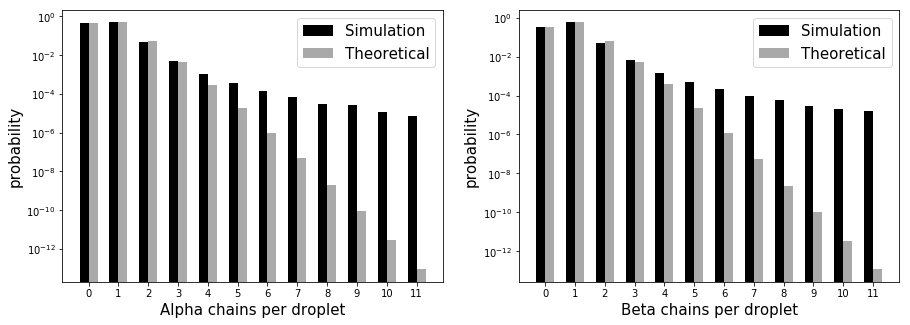

In [19]:
#Run 3 parameter model on dataset generated with 4 parameter model
df=optimization_paired(counts_alpha,counts_beta,N_random_starts=50)
accuracy_paired(counts_alpha,counts_beta,df,simulate=1)

## Infereing parameters from full model

As seen above, fitting of a simulated full distribution using a 3 parameter model results in a relatively large error in the inferred allelic inclusion rate. To address this, we next expanded our statistical model to infer the 'error' loading rate. As before, we begin by simulate alpha and beta distributions:

In [20]:
#Simulate alpha and beta distributions with same loading parameter
N=int(2e6) # number of droplets
la_real=0.08 #Poisson loading rate
ga_real=4.15 #Power law exponent error rate

f_real_a=0.083
s_real_a=0.53
counts=simulate(N,la_real,ga_real,f_real_a,s_real_a) 
counts_alpha=counts[:12]

f_real_b=0.043 #Allelic inclusion rate
s_real_b=0.39 #TCR chain droupout rate
counts=simulate(N,la_real,ga_real,f_real_b,s_real_b)
counts_beta=counts[:12]

## Updating the likelihood function
#### Likelihood
$$
\begin{array}
\
L&=&p({\rm data }|\lambda,f,\gamma,s) \\
&=&\displaystyle \prod_i^N p(x_i|\lambda,f,\gamma,s) \\
&=&\displaystyle \prod_i^N \frac{e^{-\lambda}(1-s)^x}{(1-e^{-\lambda})\zeta(\gamma,1)x!} \sum_{2m+n \geq x_i\geq1} \left(\sum\limits_{k=1}^{n+m} \frac{\lambda^{k}(n+m+1-k)^{-\gamma}}{k!}\right)\left(\frac{(m+n)!f^{m}(1-f)^{n}(2m+n)!s^{2m+n-x}}{(2m+n-x)!m!n!}\right)
\end{array}
$$
#### Log-likelihood
$$
\begin{array}
\
\mathcal{L}&=& \ln p({\rm data }|\lambda,f,\gamma,s) \\
&=& \displaystyle \sum_i^N \ln p(x_i|\lambda,f,\gamma,s) \\
&=& \displaystyle \sum_{t=0}^{\max(x)} c_t \ln p(x=t|\lambda,f,\gamma,s)
\end{array}
$$
where $c_t$ is the number of droplets that contain $t$ chains.
#### Log-likelihood per datum
For large $N$ the log-likelihood of the entire dataset can be a large negative value. It can be convenient to consider the average log-likelihood 
$$
\begin{array}
\
\mathcal{l}&=& \displaystyle \frac{1}{N} \ln p({\rm data }|\lambda,f,\gamma.s) \\
&=& \displaystyle \frac{1}{N} \sum_{t=0}^{\max(x)} c_t \ln p(x=t|\lambda,f,\gamma,s)
\end{array}
$$

#### Fitting the $\alpha$ and $\beta$ chains together

As before, the log likelihood becomes:

$$
\begin{array}
\
\mathcal{L}&=& \displaystyle\sum_{t=0}^{\max(x)}  \left(c_{t,\alpha} \ln p(x_\alpha=t|\lambda,\gamma,f_\alpha,s_\alpha) + c_{t,\beta} \ln  p(x_\beta=t|\lambda,\gamma,f_\beta,s_\beta)\right)
\end{array}
$$

In [21]:
#Optimized implementation of 4-parameter likelihood function
def p_poisson(x,la):
    return ((la**x))/((fac(x)))
def p_binomial_inclusion(n,m,f):
    return (fac(n+m)*(f**m)*((1-f)**n))/(fac(n)*fac(m))
def inclusion_probabilities(n_max,m_max,f):
    inclusions=np.zeros((n_max,m_max))
    for n in range(n_max):
        for m in range(m_max):
            inclusions[n,m]=p_binomial_inclusion(n,m,f)
    return inclusions
def p_binomial_dropout(total_chains,x,s):
    try:
        return ((fac(total_chains))*(s**(total_chains-x)))/(fac(total_chains-x))
    except:
        return 0
def p_loading_power(x,ga):
    return ((x)**(-ga))
def p_loading_convolution(x,la,ga):
    prop=0
    for k in range(1,x+1):
        prop=prop+(p_poisson(k,la)*p_loading_power(x+1-k,ga))
    return prop
def p_observing_x_chains(x,la,f,s,ga,loading,inclusion,pre,n_max=20,m_max=10):
    prefactor=pre*(((1-s)**x)/(fac(x)))
    dropout=[p_binomial_dropout(chains,x,s) for chains in range(n_max+2*m_max+1)]
    total=0
    for n in range(n_max):
        for m in range(m_max):
            if 2*m+n>=x and (m+n)!=0:
                total=total+(loading[n+m]*inclusion[n,m]*dropout[2*m+n])
    return prefactor*total

In [22]:
#Updated likelihood 
def LL(theta):
    la,ga,f_a,s_a,f_b,s_b=theta
    n_max=20
    m_max=10
    pre=(np.exp(-la))/((1-np.exp(-la))*scipy.special.zeta(ga))
    loadings=[p_loading_convolution(chains,la,ga) for chains in range(n_max+m_max+1)]
    inclusions_a=inclusion_probabilities(n_max,m_max,f_a)
    alpha=np.sum([counts_alpha[i]*np.log(p_observing_x_chains(i,la,f_a,s_a,ga,loadings,inclusions_a,pre,n_max,m_max)) for i in range(0,len(counts_alpha))])
    inclusions_b=inclusion_probabilities(n_max,m_max,f_b)
    beta=np.sum([counts_beta[i]*np.log(p_observing_x_chains(i,la,f_b,s_b,ga,loadings,inclusions_b,pre,n_max,m_max)) for i in range(0,len(counts_beta))])
    return alpha+beta

In [23]:
#Redefine optimization function for alpha/beta distributions with same lambda
def optimization_paired(counts_alpha,counts_beta,N_random_starts=50):
    warnings.simplefilter(action='ignore')
    method=['L-BFGS-B'] #['TNC','SLSQP','L-BFGS-B','Nelder-Mead']
    N_methods=len(method)
    for starting in range(N_random_starts):
        data=np.empty((N_methods,8),dtype=object)
        for it,methods in enumerate(method):
            x0=[np.random.randint(20,120)/1000,np.random.randint(40,50)/10,np.random.randint(5,15)/100,np.random.randint(25,45)/100,np.random.randint(2,9)/100,np.random.randint(45,66)/100]
            neg_LL_paired=lambda *args: -LL(*args)/np.sum(counts)
            minimum=optimize.minimize(neg_LL_paired,x0,method=methods,bounds=((0.01,.5),(2,20),(0.01,.3),(.1,.8),(0.01,.3),(.1,.8)))
            data[it]=np.hstack((minimum.x,minimum.fun,methods))
        if starting==0:
            df=data
        else:
            df=np.vstack((df,data))
    df=pd.DataFrame(df,columns=['la','ga','f_a','s_a','f_b','s_b','energy','method'])
    df=df.sort_values(by=['energy'])
    df=df[df['energy'].astype(float)>0]
    return df
df=optimization_paired(counts_alpha,counts_beta,N_random_starts=50)

Alpha Real vs. Maximum likelihood estimates
Allelic inclusion: Real- 0.083 vs. Estimated- 0.080 (3.7% difference)
Lambda: Real- 0.080 vs. Estimated- 0.087 (9.3% difference)
Gamma: Real- 4.150 vs. Estimated- 4.153 (0.1% difference)
Dropout: Real- 0.530 vs. Estimated- 0.530 (0.0% difference)
R²= 0.9999999457812342


Beta Real vs. Maximum likelihood estimates
Allelic inclusion: Real- 0.043 vs. Estimated- 0.040 (6.3% difference)
Lambda: Real- 0.080 vs. Estimated- 0.087 (9.3% difference)
Gamma: Real- 4.150 vs. Estimated- 4.153 (0.1% difference)
Dropout: Real- 0.390 vs. Estimated- 0.391 (0.2% difference)
R²= 0.999999943999932




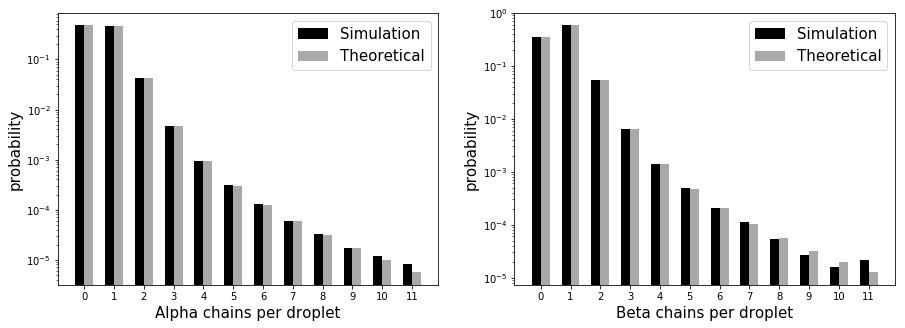

In [24]:
def px(la,f_a,ga,s_a):
    n_max=20
    m_max=10
    pre=(np.exp(-la))/((1-np.exp(-la))*scipy.special.zeta(ga))
    loadings=[p_loading_convolution(chains,la,ga) for chains in range(n_max+m_max+1)]
    inclusions_a=inclusion_probabilities(n_max,m_max,f_a)
    return [p_observing_x_chains(i,la,f_a,s_a,ga,loadings,inclusions_a,pre,n_max,m_max) for i in range(0,len(counts_alpha))]
    
def accuracy_paired(counts_alpha,counts_beta,df,simulate=1):
    names=['Alpha','Beta']
    rowname_f=['f_a','f_b']
    rowname_s=['s_a','s_b']
    if simulate==1:
        s_real=[s_real_a,s_real_b]
        f_real=[f_real_a,f_real_b]
    plt.figure(figsize=(15,5))
    for j,counts in enumerate([counts_alpha,counts_beta]):
        N=np.sum(counts)
        theory=px(float(df.iloc[0]['la']),float(df.iloc[0][rowname_f[j]]),float(df.iloc[0]['ga']),float(df.iloc[0][rowname_s[j]]))
        stat=stats.linregress(counts,theory)
        plt.subplot(1,2,j+1)
        plt.bar(range(len(counts)),counts/N,width=0.3,label='Simulation',color='Black')
        plt.bar(np.arange(len(counts))+0.3,theory,width=0.3,label='Theoretical',color='darkgray')
        plt.xticks(np.arange(len(counts))+0.15,np.arange(len(counts)))
        plt.xlabel(f'{names[j]} chains per droplet',fontsize=15)
        plt.ylabel('probability',fontsize=15)
        plt.yscale('log')
        plt.legend(fontsize=15)
        
        print(f'{names[j]} Real vs. Maximum likelihood estimates')
        
        try:
            print('Allelic inclusion: Real- {:.3f} vs. Estimated- {:.3f} ({:.1f}% difference)'.format(f_real[j],float(df.iloc[0][rowname_f[j]]),np.absolute((f_real[j]-float(df.iloc[0][rowname_f[j]]))/f_real[j])*100))
            print('Lambda: Real- {:.3f} vs. Estimated- {:.3f} ({:.1f}% difference)'.format(la_real,float(df.iloc[0]['la']),np.absolute((la_real-float(df.iloc[0]['la']))/la_real)*100))
            print('Gamma: Real- {:.3f} vs. Estimated- {:.3f} ({:.1f}% difference)'.format(ga_real,float(df.iloc[0]['ga']),np.absolute((ga_real-float(df.iloc[0]['ga']))/ga_real)*100))
            print('Dropout: Real- {:.3f} vs. Estimated- {:.3f} ({:.1f}% difference)'.format(s_real[j],float(df.iloc[0][rowname_s[j]]),np.absolute((s_real[j]-float(df.iloc[0][rowname_s[j]]))/s_real[j])*100))
            print('R\u00b2=',stat[2]**2)
        except: 
            print('Allelic inclusion: Estimated- {:.3f}'.format(float(df.iloc[0][rowname_f[j]])))
            print('Lambda: Estimated- {:.3f}'.format(float(df.iloc[0]['la'])))
            print('Gamma: Estimated- {:.3f}'.format(float(df.iloc[0]['ga'])))
            print('Dropout: Estimated- {:.3f}'.format(float(df.iloc[0][rowname_s[j]])))
            print('R\u00b2=',stat[2]**2)
        print('\n')
    plt.show()
    plt.close()
accuracy_paired(counts_alpha,counts_beta,df,simulate=1)

### 4-parameter model on experimental data

In [25]:
counts_alpha=np.array([818819, 795095, 73104, 7880, 1560, 558, 212, 131, 67, 46, 24, 12, 16, 11, 3, 3, 1, 1, 3, 1, 1, 2])
counts_beta=np.array([602628, 989821, 90413, 10733, 2261, 762, 376, 224, 116, 75, 54, 25, 14, 18, 10, 4, 5, 1, 1, 5, 2, 1, 1])

counts_alpha=counts_alpha[:12]
counts_beta=counts_beta[:12]

Alpha Real vs. Maximum likelihood estimates
Allelic inclusion: Estimated- 0.085
Lambda: Estimated- 0.078
Gamma: Estimated- 4.154
Dropout: Estimated- 0.532
R²= 0.999999886936758


Beta Real vs. Maximum likelihood estimates
Allelic inclusion: Estimated- 0.044
Lambda: Estimated- 0.078
Gamma: Estimated- 4.154
Dropout: Estimated- 0.392
R²= 0.999999924921046




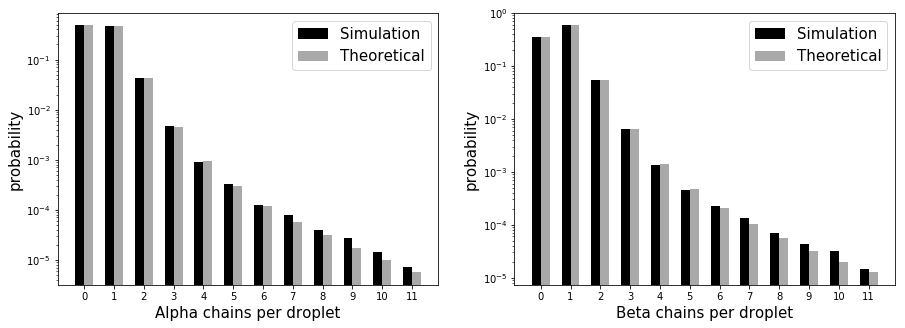

In [26]:
df=optimization_paired(counts_alpha,counts_beta,N_random_starts=50)
accuracy_paired(counts_alpha,counts_beta,df,simulate=0)